In [1]:
import os
import shutil
import copy
import sys
import torch
import pprint
import numpy as np
import pandas as pd
import functools

from torchinfo import summary
from IPython.display import YouTubeVideo
from IPython.display import clear_output
from roboflow import Roboflow

In [2]:
from super_gradients.training import models
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import training_hyperparams
from super_gradients.training.metrics.metric_utils import get_metrics_dict
from super_gradients.training.utils.quantization.calibrator import QuantizationCalibrator
from super_gradients.training.utils.quantization.export import export_quantized_module_to_onnx
from super_gradients.training.utils.quantization.selective_quantization_utils import SelectiveQuantizer
from super_gradients.training.utils.checkpoint_utils import adaptive_load_state_dict
from super_gradients.common.environment.checkpoints_dir_utils import get_checkpoints_dir_path

In [3]:
# outpath = 'Z:/CompCarsYolo/model/'
# loc = 'Z:/anaconda3/envs/gpu_env/Lib/site-packages/super_gradients/recipes/'

# rf = Roboflow(api_key="u5EbQMhc5BW6bhrnZWYy")
# project = rf.workspace("research-projects-qodgb").project("vehicle-body-style-dataset")
# dataset = project.version(2).download(model_format="coco", location="./content/vehicle-body-style-dataset-2-coco")

In [4]:
# super_gradients.convert_recipe_to_code('roboflow_yolo_nas_s_qat', loc, outpath)

In [5]:
class config:
    #trainer params
    CHECKPOINT_DIR = './content/checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'yolo_car_type_identifier_qat' #specify the experiment name

    #dataset params
    DATA_DIR = './content/vehicle-body-style-dataset-2-yolov5/' #parent directory to where data lives
    DATA_NAME = 'vehicle-body-style-dataset-2-coco'

    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'valid/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'valid/labels' #child dir of DATA_DIR where validation labels are

    # if you have a test set
    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['MPV', 'SUV', 'sedan', 'hatchback', 'minibus', 'fastback', 'estate',
               'pickup', 'hardtop convertible', 'sports', 'crossover', 'convertible'] #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS = {
        'batch_size':16,
        'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_s' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

In [6]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

In [7]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES,
        'input_dim': [320, 320]
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES,
        'input_dim': [320, 320]
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES,
        'input_dim': [320, 320]
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Indexing dataset annotations: 100%|█████████████████████████████████████████████████████████████████████████████| 987/987 [00:00<00:00, 3709.71it/s]


Indexing dataset annotations: 100%|████████████████████████████████████████████████| 987/987 [00:00<00:00, 3167.50it/s]


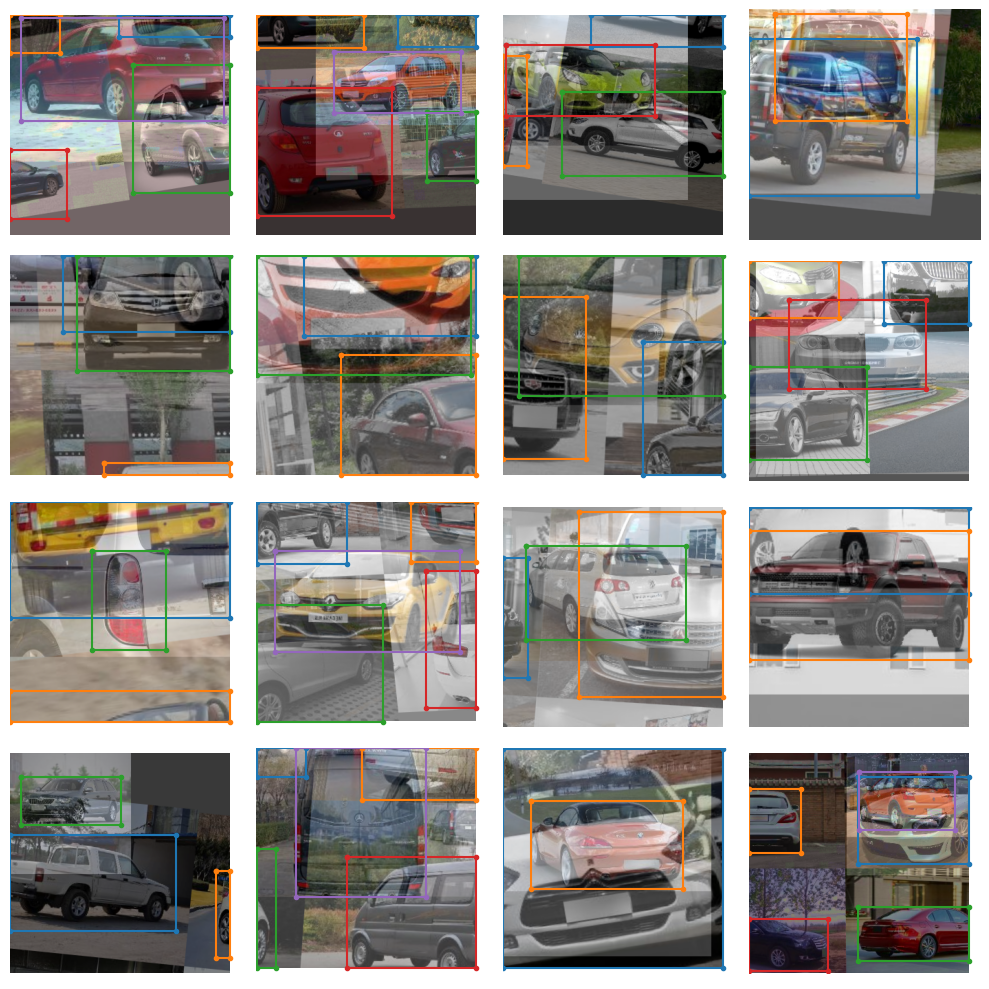

In [8]:
train_data.dataset.plot()

In [9]:
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

In [17]:
train_params = {
    'average_best_models': True,
    'zero_weight_decay_on_bias_and_bn': True,
    'lr_warmup_epochs': 3,
    'warmup_mode': 'LinearEpochLRWarmup',
    'initial_lr': 5e-4,
    'cosine_final_lr_ratio': 0.1,
    'optimizer': "Adam",
    'optimizer_params': {
        'weight_decay': 0.0001 },
    'ema': True,
    'ema_params': {
        'decay': 0.9 },
    'max_epochs': 30,
    'mixed_precision': True,
    # 'criterion_params': [
    #     'num_classes': config.NUM_CLASSES
    #     'reg_max': 16 ]

     "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),

    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls= config.NUM_CLASSES,
            normalize_targets = True,
            post_prediction_callback = PPYoloEPostPredictionCallback(
                score_threshold = 0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [11]:
!python /anaconda3/envs/gpu_env/Lib/site-packages/tensorboard/main.py --logdir ./content/checkpoints

In [13]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

Train epoch 0: 100%|██████████| 438/438 [02:19<00:00,  3.14it/s, PPYoloELoss/loss=2.23, PPYoloELoss/loss_cls=1.43, PPYoloELoss/loss_dfl=0.461, PPYol
Validating: 100%|██████████| 124/124 [00:36<00:00,  3.41it/s]
Train epoch 1: 100%|██████████| 438/438 [02:18<00:00,  3.16it/s, PPYoloELoss/loss=2.01, PPYoloELoss/loss_cls=1.3, PPYoloELoss/loss_dfl=0.417, PPYolo
Validating epoch 2: 100%|██████████| 124/124 [00:36<00:00,  3.42it/s]


In [18]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path='./content/checkpoints/yolo_car_type_identifier_qat/RUN_20231207_135514_373944/average_model.pth')

In [19]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 61/61 [00:39<00:00,  1.54it/s]


{'PPYoloELoss/loss_cls': 1.3099502,
 'PPYoloELoss/loss_iou': 0.1861581,
 'PPYoloELoss/loss_dfl': 0.3389592,
 'PPYoloELoss/loss': 1.8350668,
 'Precision@0.50': 0.017414694651961327,
 'Recall@0.50': 0.9990530014038086,
 'mAP@0.50': 0.27044740319252014,
 'F1@0.50': 0.034205641597509384}

In [106]:
from super_gradients.modules.repvgg_block import fuse_repvgg_blocks_residual_branches

def load_checkpoint(model, ckpt_file):
  state_dict = torch.load(ckpt_file, map_location="cuda")
  ckpt_key = "ema_net" if "ema_net" in state_dict else "net"
  adaptive_load_state_dict(model, state_dict[ckpt_key], strict="no_key_matching")

def validate_model(model, dataloader, training_hyperparams):
  trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

  val_results_tuple = trainer.test(model=model, test_loader=dataloader, test_metrics_list=train_params["valid_metrics_list"])
  valid_metrics_dict = get_metrics_dict(val_results_tuple, trainer.test_metrics, trainer.loss_logging_items_names)

  results = ["Validate Results"]
  results += [f"{metric:4}: {value}" for metric, value in val_results_tuple.items()]

  res_string = "\r\n".join(results)

  print(res_string, file=sys.stderr)

  return res_string

In [107]:
from torch import nn

def quantize_and_calibrate(
    model: nn.Module,
    calibration_dataloader,
    num_calib_batches=16,             # number of batches to use for calibration
    method_w="max",                   # calibrator type for weights, acceptable types are ["max", "histogram"]
    method_i="histogram",             # calibrator type for inputs, acceptable types are ["max", "histogram"]
    calibration_method="percentile",  # calibration method for all "histogram" calibrators, acceptable types are ["percentile", "entropy", mse"], "max" calibrators are not affected
    percentile=99.99,                 # percentile for all histogram calibrators with method "percentile", other calibrators are not affected
    per_channel=True,                 # per-channel quantization of weights, activations stay per-tensor by default
    learn_amax=False,                 # enable learnable amax in all TensorQuantizers using straight-through estimator
    skip_modules=None,                # optional list of module names (strings) to skip from quantization
    verbose=False,                    # if calibrator should be verbose
):
    model.eval()

    q_util = SelectiveQuantizer(
        default_quant_modules_calibrator_weights=method_w,
        default_quant_modules_calibrator_inputs=method_i,
        default_per_channel_quant_weights=per_channel,
        default_learn_amax=learn_amax,
        verbose=verbose
    )

    if skip_modules is not None:
        q_util.register_skip_quantization(layer_names=set(skip_modules))

    calibrator = QuantizationCalibrator(verbose=verbose, torch_hist=True)

    # RepVGG and QARepVGG can be quantized only in the fused form
    fuse_repvgg_blocks_residual_branches(model)
    q_util.quantize_module(model)

    calibrator.calibrate_model(
        model,
        method=calibration_method,
        calib_data_loader=calibration_dataloader,
        num_calib_batches=num_calib_batches,
        percentile=percentile,
    )

    model.train()
    return model

In [112]:
load_checkpoint(model, os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))
ptq_model = quantize_and_calibrate(copy.deepcopy(model),
                                    train_data,
                                    num_calib_batches=4,
                                    method_w="max",
                                    method_i="histogram",
                                    calibration_method="percentile",
                                    percentile=99.99,
                                    per_channel=True,
                                    learn_amax=False,
                                    skip_modules=None,
                                    verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.19s/it]


In [50]:
validate_model(ptq_model, val_data, train_params)

Testing: 100%|██████████| 124/124 [00:32<00:00,  9.30it/s]

'Validate Results\r\nPrecision@0.50: 0.01945129968225956\r\nRecall@0.50: 0.9989959597587585\r\nmAP@0.50: 0.2683492600917816\r\nF1@0.50: 0.03812944516539574'

Testing: 100%|██████████| 124/124 [00:33<00:00,  3.69it/s]
Validate Results
Precision@0.50: 0.01945129968225956
Recall@0.50: 0.9989959597587585
mAP@0.50: 0.2683492600917816
F1@0.50: 0.03812944516539574


In [51]:
train_params["max_epochs"] = 10
train_params["initial_lr"] = 1e-4
train_params["warmup_initial_lr"] = 1e-6
train_params["weight_decay"] = 1e-5
train_params["lr_mode"] = "cosine"
train_params["lr_warmup_epochs"] = 1
train_params["cosine_final_lr_ratio"] = 0.01
train_params["ema"] = False

train_data.dataset.transforms = copy.deepcopy(val_data.dataset.transforms)

In [52]:
trainer_qat = Trainer(experiment_name=f"{config.EXPERIMENT_NAME}", ckpt_root_dir=config.CHECKPOINT_DIR)
trainer_qat.train(model=ptq_model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

Train epoch 0: 100%|██████████| 438/438 [01:41<00:00,  4.31it/s, PPYoloELoss/loss=1.75, PPYoloELoss/loss_cls=1.31, PPYoloELoss/loss_dfl=0.31, PPYolo
Validating: 100%|██████████| 124/124 [00:34<00:00,  3.60it/s]
Train epoch 1: 100%|██████████| 438/438 [01:40<00:00,  4.37it/s, PPYoloELoss/loss=1.48, PPYoloELoss/loss_cls=1.09, PPYoloELoss/loss_dfl=0.291, PPYol
Validating epoch 1: 100%|██████████| 124/124 [00:38<00:00,  3.23it/s]
Train epoch 2: 100%|██████████| 438/438 [02:10<00:00,  3.34it/s, PPYoloELoss/loss=1.34, PPYoloELoss/loss_cls=0.979, PPYoloELoss/loss_dfl=0.28, PPYol
Validating epoch 2: 100%|██████████| 124/124 [00:35<00:00,  3.52it/s]
Train epoch 3: 100%|██████████| 438/438 [01:41<00:00,  4.30it/s, PPYoloELoss/loss=1.21, PPYoloELoss/loss_cls=0.863, PPYoloELoss/loss_dfl=0.275, PPYo
Validating epoch 3: 100%|██████████| 124/124 [00:35<00:00,  3.54it/s]
Train epoch 4: 100%|██████████| 438/438 [01:41<00:00,  4.30it/s, PPYoloELoss/loss=1.1, PPYoloELoss/loss_cls=0.76, PPYoloELoss/loss_d

In [53]:
load_checkpoint(ptq_model, os.path.join(trainer_qat.checkpoints_dir_path, "ckpt_best.pth"))
validate_model(ptq_model, val_data, train_params)

Testing: 100%|██████████| 124/124 [00:31<00:00,  9.32it/s]

'Validate Results\r\nPrecision@0.50: 0.3626929521560669\r\nRecall@0.50: 0.9073948264122009\r\nmAP@0.50: 0.6557263731956482\r\nF1@0.50: 0.505256712436676'

Testing: 100%|██████████| 124/124 [00:32<00:00,  3.77it/s]
Validate Results
Precision@0.50: 0.3626929521560669
Recall@0.50: 0.9073948264122009
mAP@0.50: 0.6557263731956482
F1@0.50: 0.505256712436676


In [258]:
from PIL import Image
import requests
from torchvision.transforms import transforms as T
from matplotlib import pyplot as plt
from super_gradients.training.utils.detection_utils import DetectionVisualization
from super_gradients.training.datasets.datasets_conf import COCO_DETECTION_CLASSES_LIST
import cv2 as cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

img = cv2.imread("./content/single_vehicle_test.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

model = ptq_model.to(device)
predictions = model.predict(img, conf=0.3)

for image_prediction in predictions:
    class_names = image_prediction.class_names
    labels = image_prediction.prediction.labels
    confidence = image_prediction.prediction.confidence
    bboxes = image_prediction.prediction.bboxes_xyxy

    for i, (label, conf, bbox) in enumerate(zip(labels, confidence, bboxes)):
        print("prediction: ", i, file=sys.stderr)
        print("label_id: ", label, file=sys.stderr)
        print("label_name: ", class_names[int(label)], file=sys.stderr)
        print("confidence: ", conf, file=sys.stderr)
        print("bbox: ", bbox, file=sys.stderr)
        print("--" * 10, file=sys.stderr)
# # ptq_model.eval()
# _image = np.array(Image.open('./content/single_vehicle_test.jpg'))
# im = torch.from_numpy(_image).unsqueeze_(0)
# # set up transformation to resize the image
# resize = T.Resize((32, 32))
# im = resize(im)

# # to_tensor = T.ToTensor()
# # # apply transformation and convert to Pytorch tensor
# # tens = to_tensor(im)
# # torch.Size([3, 224, 224])
# tens = torch.permute(im, (0,2,3, 1))
# norm_t = T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
# # add another dimension at the front to get NCHW shape
# print(tens.size(), file=sys.stderr)
# tens = norm_t(tens.float())
# input_tensor = tens.unsqueeze_(0).to(next(ptq_model.parameters()).device)
# print(input_tensor.size(), file=sys.stderr)

# def temp_test():
#     with torch.no_grad():
#         ptq_model.eval()
#         predictions, scores = ptq_model(input_tensor)
#         print(scores, file=sys.stderr)
#         classes = train_data.dataset.classes
#         name = classes[scores[0]]
#         return name
        
# name = temp_test()
# print(name, file=sys.stderr)
# plt.imshow(im)

prediction:  0
label_id:  0.0
label_name:  MPV
confidence:  0.4111
bbox:  [  29.53125    53.671875 1159.6875    588.75    ]
--------------------
prediction:  1
label_id:  2.0
label_name:  sedan
confidence:  0.379
bbox:  [  29.53125    53.671875 1159.6875    588.75    ]
--------------------
prediction:  2
label_id:  1.0
label_name:  SUV
confidence:  0.3545
bbox:  [  29.53125    53.671875 1159.6875    588.75    ]
--------------------
prediction:  3
label_id:  3.0
label_name:  hatchback
confidence:  0.353
bbox:  [  30.9375   58.125  1158.75    592.5   ]
--------------------
prediction:  4
label_id:  9.0
label_name:  sports
confidence:  0.3518
bbox:  [  29.53125    53.671875 1159.6875    588.75    ]
--------------------
prediction:  5
label_id:  4.0
label_name:  minibus
confidence:  0.3452
bbox:  [  29.53125    53.671875 1159.6875    588.75    ]
--------------------
prediction:  6
label_id:  8.0
label_name:  hardtop convertible
confidence:  0.3416
bbox:  [  29.53125    53.671875 1159.6875 

In [263]:
import torch
from torch.utils.data import DataLoader
from super_gradients.conversion import DetectionOutputFormatMode
from super_gradients.conversion import ExportQuantizationMode

export_result = best_model.export(
    "yolo_nas_s_int8_with_calibration.onnx",
    output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT,
    quantization_mode=ExportQuantizationMode.INT8,
    calibration_loader=val_data
)
# dummy_input = torch.randn([1, 3, 32, 32], device="cpu")
# export_quantized_module_to_onnx(
#     model=ptq_model.cpu(),
#     onnx_filename=onnx_filename,
#     input_shape=[1, 3, 32, 32],
#     input_size=[1, 3, 32, 32],
#     train=False,
# )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  1.78s/it]


In [264]:
export_result

Model exported successfully to yolo_nas_s_int8_with_calibration.onnx
Model expects input image of shape [1, 3, 320, 320]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0]))
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.65
    confidence_threshold=0.5
    output_predictions_format=flat

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("yolo_nas_s_int8_with_calibration.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    i